In [1]:
import scanpy as sc
import pandas as pd
import geopandas as gpd

In [2]:
adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final.h5ad')

In [3]:
gdf = gpd.read_file('../data/xenium/voronoi_tresholded_buffered.geojson')
gdf.crs = None

In [4]:
coords = adata.obs[['center_x', 'center_y']]

# Create a DataFrame
coords_df = pd.DataFrame(coords)

In [5]:
points_gdf = gpd.GeoDataFrame(coords_df, geometry=gpd.points_from_xy(coords_df.center_x, coords_df.center_y))

# Ensure the CRS matches with your existing GeoDataFrame
points_gdf.crs = None

In [7]:
stardist = gpd.read_file('../data/xenium/stardist_all.geojson')

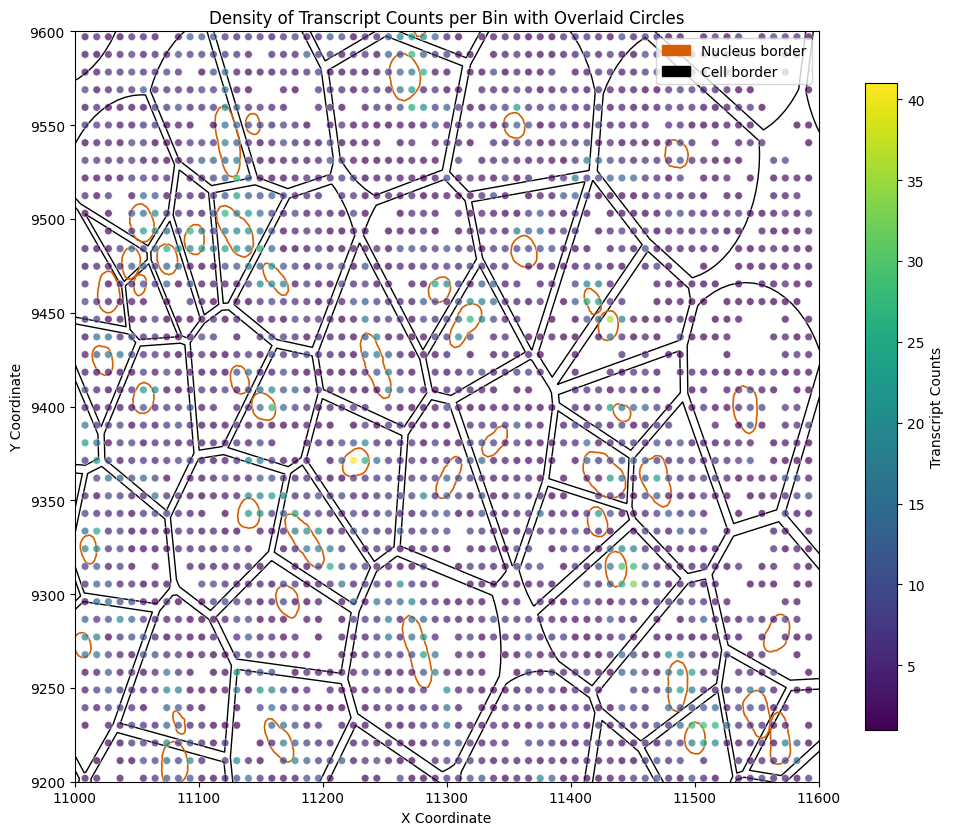

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from shapely.geometry import box
import geopandas as gpd

# Define bounding box
bbox = (11000, 9200, 11600, 9600)  # xmin, ymin, xmax, ymax

# Define colors with better contrast and accessibility
cell_border_color = '#000000'  # Black
nucleus_border_color = '#D55E00'  # Dark orange (distinguishable for color blindness)

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the GeoDataFrame polygons within the bounding box
gdf_clip = gdf[gdf.intersects(box(*bbox))]  # Filter GeoDataFrame
gdf_clip.plot(ax=ax, edgecolor=cell_border_color, facecolor='none', linewidth=1.0)

stardist_clip = stardist[stardist.intersects(box(*bbox))]  # Filter GeoDataFrame
stardist_clip.plot(ax=ax, edgecolor=nucleus_border_color, facecolor='none', linewidth=1.2)

# Extract and filter coordinates from the AnnData object
coords_df = pd.DataFrame(adata.obs[['center_x', 'center_y', 'total_counts']])
coords_df = coords_df.dropna()  # Drop any rows with NaN values

# Filter coordinates based on the bounding box
coords_df_filtered = coords_df[
    (coords_df['center_x'] >= bbox[0]) &
    (coords_df['center_x'] <= bbox[2]) &
    (coords_df['center_y'] >= bbox[1]) &
    (coords_df['center_y'] <= bbox[3])
]

# Overlay the points on the KDE plot
sns.scatterplot(
    x=coords_df_filtered['center_x'],
    y=coords_df_filtered['center_y'],
    hue=coords_df_filtered['total_counts'],
    palette='viridis',
    ax=ax,
    legend=None,
    marker='o',
    s=30,  # Adjust size as needed
    alpha=0.7
)

# Set plot limits based on bounding box
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=coords_df_filtered['total_counts'].min(), vmax=coords_df_filtered['total_counts'].max()))
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Transcript Counts')

# Add legend
legend_elements = [
    Patch(color=nucleus_border_color, label='Nucleus border'),
    Patch(color=cell_border_color, label='Cell border'),
]
ax.legend(handles=legend_elements, loc='upper right')

# Set title and labels
plt.title('Density of Transcript Counts per Bin with Overlaid Circles')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()


In [74]:
import numpy as np
import pandas as pd

def fast_pdf(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

def compute_std_dev_from_area(gdf, k=1):
    # Compute std_dev based on the area of each polygon
    gdf['area'] = gdf['geometry'].area
    gdf['std_dev'] = k * np.sqrt(gdf['area'])
    return gdf

def assign_transcripts_to_polygons(transcripts_df, gdf, batch_size=1000):
    # Convert centroids to numpy array
    print('Convert centroids to numpy array')
    gdf['centroid'] = gdf['geometry'].centroid
    polygon_centroids = np.array([(p.x, p.y) for p in gdf['centroid']])
    
    # Extract transcript coordinates and total_counts
    print('Extract transcript coordinates and total_counts')
    transcript_coords = transcripts_df[['center_x', 'center_y']].values
    transcript_counts = transcripts_df['total_counts'].values

    # Precompute squared norms
    print('Precompute squared norms')
    polygon_centroids_sq = np.sum(polygon_centroids**2, axis=1)[np.newaxis, :]

    # Initialize lists to collect weighted probabilities and chosen probabilities
    print('Compute distances and probabilities in batches')
    weighted_probabilities_list = []
    chosen_probabilities = []

    # Process in batches
    for i in range(0, len(transcript_coords), batch_size):
        transcript_batch = transcript_coords[i:i + batch_size]
        batch_transcript_sq = np.sum(transcript_batch**2, axis=1)[:, np.newaxis]
        batch_distances = np.sqrt(batch_transcript_sq + polygon_centroids_sq - 2 * np.dot(transcript_batch, polygon_centroids.T))

        # Extract std_dev for each polygon
        batch_std_dev = gdf['std_dev'].values * 2

        # Penalize distances: the further away, the smaller the probability
        distance_penalty = np.exp(-batch_distances / batch_std_dev)

        # Calculate probabilities for the current batch
        batch_probabilities = np.zeros_like(batch_distances)
        for j in range(len(batch_std_dev)):
            # Adjust probability calculation by both distance penalty and total_counts
            batch_probabilities[:, j] = (fast_pdf(batch_distances[:, j] / batch_std_dev[j]) / batch_std_dev[j]) * transcript_counts[i:i + batch_size] * distance_penalty[:, j]

        # Collect the weighted probabilities
        weighted_probabilities_list.append(batch_probabilities)

    # Combine weighted probabilities from all batches
    weighted_probabilities = np.vstack(weighted_probabilities_list)

    # Normalize the weighted probabilities to sum to 1
    print('Normalize the weighted probabilities to sum to 1')
    normalized_probabilities = weighted_probabilities / np.sum(weighted_probabilities, axis=1, keepdims=True)
    
    # Create a cumulative probability array for each transcript
    print('Create a cumulative probability array for each transcript')
    cumulative_probabilities = np.cumsum(normalized_probabilities, axis=1)
    
    # Generate random numbers for sampling
    random_values = np.random.rand(len(transcripts_df))
    
    # Determine chosen polygon indices
    print('Choose indices and extract probabilities')
    chosen_polygon_indices = np.argmax(cumulative_probabilities >= random_values[:, np.newaxis], axis=1)
    
    # Extract the corresponding probabilities
    chosen_probabilities = normalized_probabilities[np.arange(len(transcripts_df)), chosen_polygon_indices]
    
    # Assign polygon IDs and probabilities to transcripts
    print('Assign polygon IDs and probabilities to transcripts')
    transcripts_df.loc[:, 'assigned_polygon_id'] = gdf['id'].values[chosen_polygon_indices]
    transcripts_df.loc[:, 'assignment_probability'] = chosen_probabilities
    
    return transcripts_df

def process_large_dataset_in_batches(adata_obs, gdf, outer_batch_size=2000, inner_batch_size=1000):
    # Compute std_dev based on area
    gdf = compute_std_dev_from_area(gdf)

    # Initialize list to collect results from each outer batch
    results_list = []

    # Process in outer batches
    for start_idx in range(0, len(adata_obs), outer_batch_size):
        end_idx = min(start_idx + outer_batch_size, len(adata_obs))
        print(f'Processing batch {start_idx} to {end_idx}')
        
        # Extract the current batch from adata_obs
        batch_obs = adata_obs.iloc[start_idx:end_idx]

        # Call assign_transcripts_to_polygons on the current batch
        batch_result = assign_transcripts_to_polygons(batch_obs, gdf, batch_size=inner_batch_size)
        
        # Collect the result
        results_list.append(batch_result)

    # Combine results from all outer batches
    full_result = pd.concat(results_list, ignore_index=True)
    
    return full_result

# Example usage
transcripts_with_assignments2 = process_large_dataset_in_batches(coords_df_filtered, stardist_clip, outer_batch_size=2000, inner_batch_size=1000)

# Save to CSV
csv_file_path = 'transcripts_with_assignments.csv'
transcripts_with_assignments2.to_csv(csv_file_path, index=False)


Processing batch 0 to 2000
Convert centroids to numpy array
Extract transcript coordinates and total_counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices and extract probabilities
Assign polygon IDs and probabilities to transcripts
Processing batch 2000 to 2412
Convert centroids to numpy array
Extract transcript coordinates and total_counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices and extract probabilities
Assign polygon IDs and probabilities to transcripts


/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_82309/269603772.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['area'] = gdf['geometry'].area
/Users/lollijagladiseva/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_82309/269603772.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid']

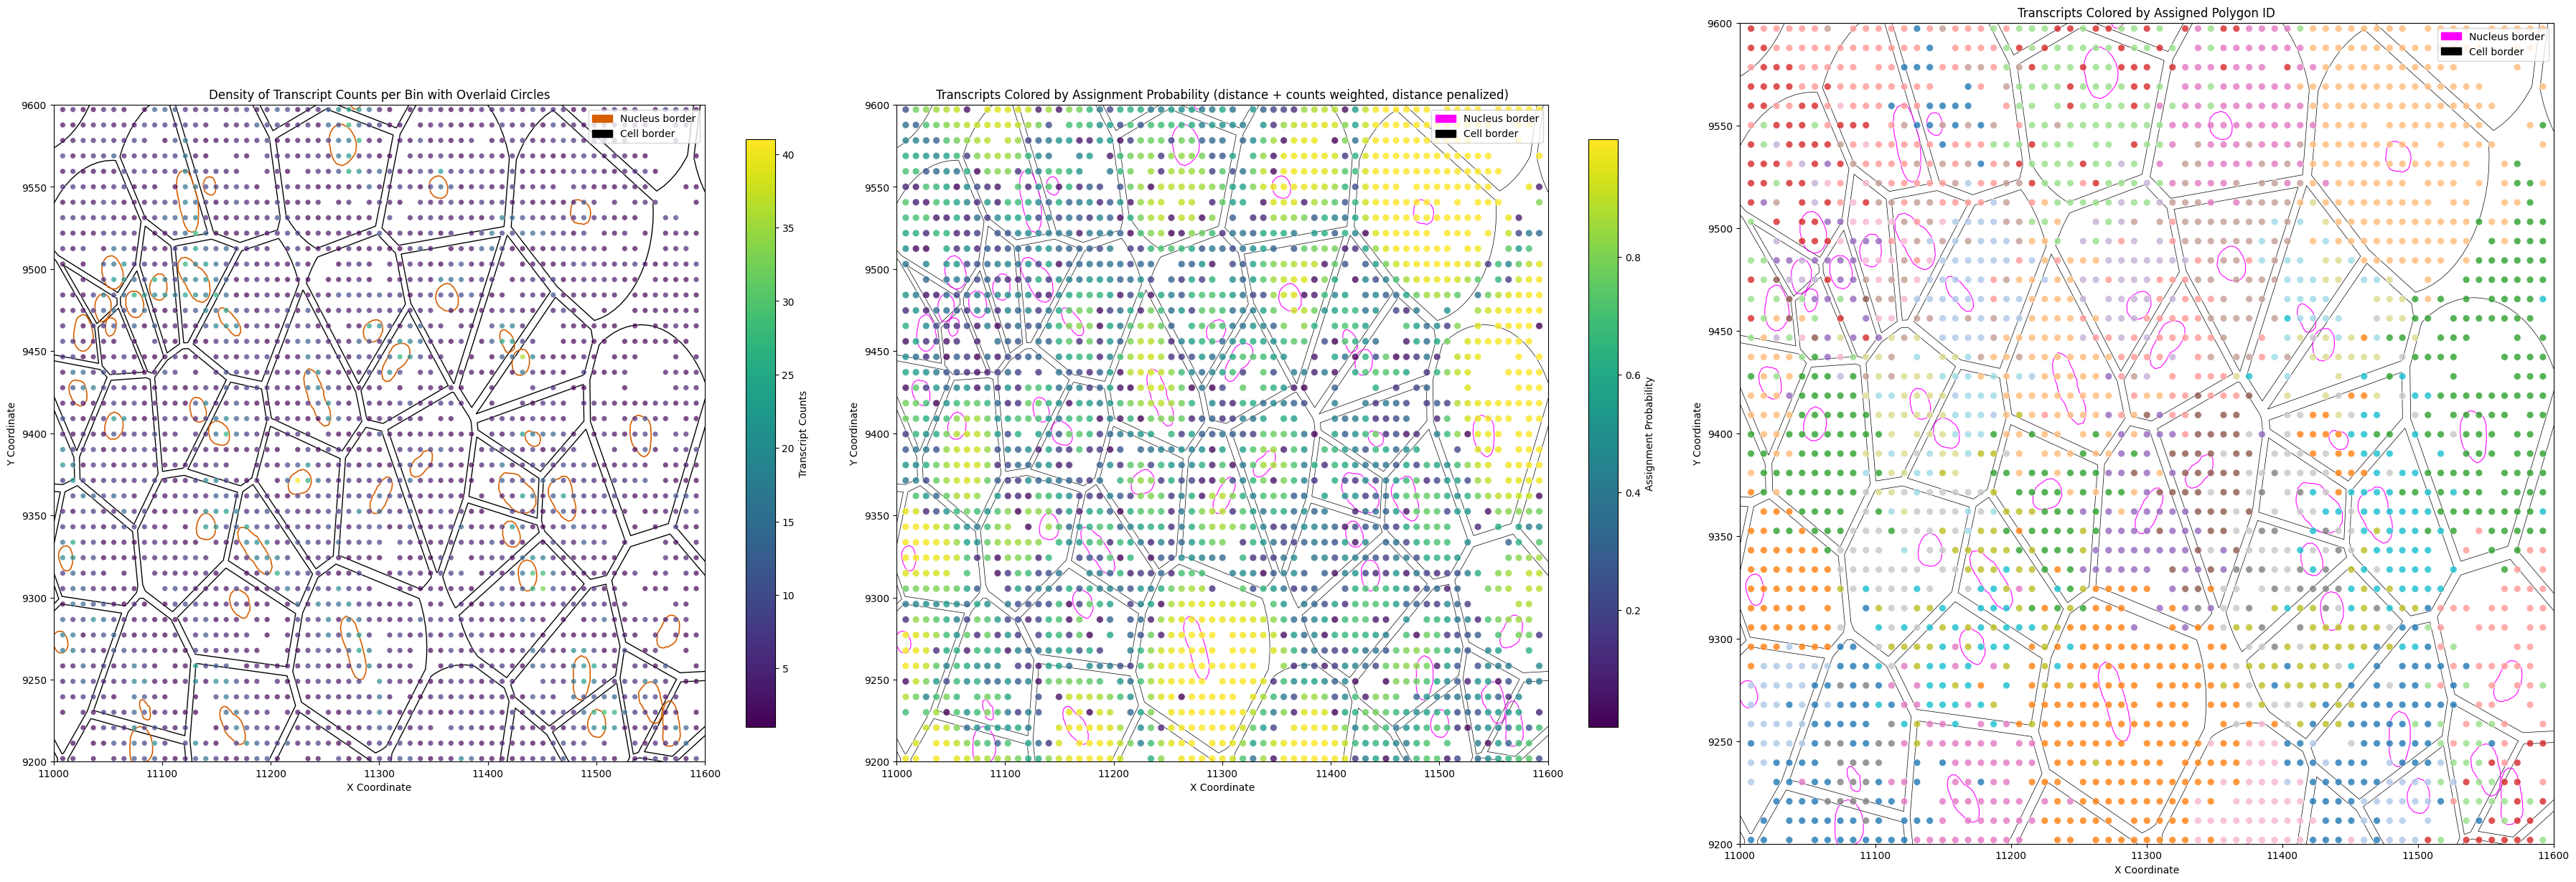

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch
from shapely.geometry import box
import geopandas as gpd

# Define bounding box
bbox = (11000, 9200, 11600, 9600)  # xmin, ymin, xmax, ymax

# Define colors with better contrast and accessibility
cell_border_color = '#000000'  # Black
nucleus_border_color = '#D55E00'  # Dark orange (distinguishable for color blindness)

# Create a subplot layout with 3 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(36, 12))  # 3 plots in one row

# Define a function to create the density plot (the first plot in your original request)
def plot_density(ax):
    # Plot the GeoDataFrame polygons within the bounding box
    gdf_clip = gdf[gdf.intersects(box(*bbox))]  # Filter GeoDataFrame
    gdf_clip.plot(ax=ax, edgecolor=cell_border_color, facecolor='none', linewidth=1.0)

    stardist_clip = stardist[stardist.intersects(box(*bbox))]  # Filter GeoDataFrame
    stardist_clip.plot(ax=ax, edgecolor=nucleus_border_color, facecolor='none', linewidth=1.2)

    # Extract and filter coordinates from the AnnData object
    coords_df = pd.DataFrame(adata.obs[['center_x', 'center_y', 'total_counts']])
    coords_df = coords_df.dropna()  # Drop any rows with NaN values

    # Filter coordinates based on the bounding box
    coords_df_filtered = coords_df[
        (coords_df['center_x'] >= bbox[0]) &
        (coords_df['center_x'] <= bbox[2]) &
        (coords_df['center_y'] >= bbox[1]) &
        (coords_df['center_y'] <= bbox[3])
    ]

    # Overlay the points on the plot
    sns.scatterplot(
        x=coords_df_filtered['center_x'],
        y=coords_df_filtered['center_y'],
        hue=coords_df_filtered['total_counts'],
        palette='viridis',
        ax=ax,
        legend=None,
        marker='o',
        s=30,  # Adjust size as needed
        alpha=0.7
    )

    # Set plot limits based on bounding box
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=coords_df_filtered['total_counts'].min(), vmax=coords_df_filtered['total_counts'].max()))
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('Transcript Counts')

    # Add legend
    legend_elements = [
        Patch(color=nucleus_border_color, label='Nucleus border'),
        Patch(color=cell_border_color, label='Cell border'),
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    # Set title and labels
    ax.set_title('Density of Transcript Counts per Bin with Overlaid Circles')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

# Define a function to create the transcript assignment plot (for the second dataset)
def plot_transcripts_with_assignments(ax, transcripts_with_assignments, title):
    # Plot the GeoDataFrame polygons (cell borders) within the bounding box
    gdf_clip.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)

    # Plot the nucleus borders within the bounding box
    stardist_clip.plot(ax=ax, edgecolor='magenta', facecolor='none', linewidth=0.8)

    # Plot the transcript data points, colored by assignment probability
    sns.scatterplot(
        x=transcripts_with_assignments['center_x'],
        y=transcripts_with_assignments['center_y'],
        hue=transcripts_with_assignments['assignment_probability'],
        palette='viridis',
        ax=ax,
        marker='o',
        s=50,  # Adjust size as needed
        alpha=0.8
    )

    # Set plot limits based on bounding box
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])

    # Add colorbar for assignment probability
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=transcripts_with_assignments['assignment_probability'].min(), vmax=transcripts_with_assignments['assignment_probability'].max()))
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('Assignment Probability')

    # Add legend for nucleus and cell borders
    legend_elements = [
        Patch(color='magenta', label='Nucleus border'),
        Patch(color='black', label='Cell border'),
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

# Define a function to create the third plot with transcript assignments colored by polygon ID
def plot_transcripts_by_polygon_id(ax, transcripts_with_assignments, title):
    # Plot the GeoDataFrame polygons (cell borders) within the bounding box
    gdf_clip.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)

    # Plot the nucleus borders within the bounding box
    stardist_clip.plot(ax=ax, edgecolor='magenta', facecolor='none', linewidth=0.8)

    # Plot the transcript data points, colored by polygon ID
    sns.scatterplot(
        x=transcripts_with_assignments['center_x'],
        y=transcripts_with_assignments['center_y'],
        hue=transcripts_with_assignments['assigned_polygon_id'],  # Color by polygon ID
        palette='tab20',  # Use a categorical colormap
        ax=ax,
        marker='o',
        s=50,  # Adjust size as needed
        alpha=0.8
    )

    # Set plot limits based on bounding box
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])

    # Add legend for nucleus and cell borders
    legend_elements = [
        Patch(color='magenta', label='Nucleus border'),
        Patch(color='black', label='Cell border'),
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

# Plot the density plot as the first plot
plot_density(axes[0])

# Plot the transcript assignment by probability (second plot)
plot_transcripts_with_assignments(axes[1], transcripts_with_assignments2, 'Transcripts Colored by Assignment Probability (distance + counts weighted, distance penalized)')

# Plot the transcript assignment by polygon ID (third plot)
plot_transcripts_by_polygon_id(axes[2], transcripts_with_assignments2, 'Transcripts Colored by Assigned Polygon ID')

# Adjust layout for better spacing
plt.tight_layout()

# Show the final plots
plt.show()


In [96]:
import numpy as np
import pandas as pd
from shapely.geometry import Point

def fast_pdf(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

def compute_std_dev_from_area(gdf, k=0.3):  # Small influence from nucleus size
    # Compute std_dev based on the area of each polygon
    gdf['area'] = gdf['geometry'].area
    gdf['std_dev'] = k * np.sqrt(gdf['area'])  # Apply a small multiplier to reduce influence
    return gdf

def assign_transcripts_to_polygons(transcripts_df, gdf, batch_size=1000):
    # Initialize lists to collect weighted probabilities and chosen probabilities
    weighted_probabilities_list = []
    
    # Process in batches
    for i in range(0, len(transcripts_df), batch_size):
        transcript_batch = transcripts_df.iloc[i:i + batch_size]

        # Initialize an empty array to hold the distances
        batch_distances = np.zeros((len(transcript_batch), len(gdf)))

        # Loop through each polygon and compute the distance from each transcript to the polygon's boundary
        for j, polygon in enumerate(gdf['geometry']):
            batch_distances[:, j] = transcript_batch.apply(
                lambda row: polygon.boundary.distance(Point(row['center_x'], row['center_y'])), axis=1
            )

        # Extract std_dev for each polygon
        batch_std_dev = gdf['std_dev'].values

        # Penalize distances: ensure penalty does not result in zero probabilities
        distance_penalty = np.exp(-batch_distances / (batch_std_dev + 1e-9))  # Add small epsilon to prevent division by zero

        # Calculate probabilities for the current batch
        batch_probabilities = np.zeros_like(batch_distances)
        for j in range(len(batch_std_dev)):
            # Adjust probability calculation by both distance penalty and total_counts
            batch_probabilities[:, j] = (fast_pdf(batch_distances[:, j] / batch_std_dev[j]) / (batch_std_dev[j] + 1e-9)) * transcript_batch['total_counts'].values * distance_penalty[:, j]

        # Collect the weighted probabilities
        weighted_probabilities_list.append(batch_probabilities)

    # Combine weighted probabilities from all batches
    weighted_probabilities = np.vstack(weighted_probabilities_list)

    # Normalize the weighted probabilities to sum to 1 for each transcript
    probability_sums = np.sum(weighted_probabilities, axis=1, keepdims=True)
    normalized_probabilities = weighted_probabilities / (probability_sums + 1e-9)  # Avoid division by zero

    # Create a cumulative probability array for each transcript
    cumulative_probabilities = np.cumsum(normalized_probabilities, axis=1)
    
    # Generate random numbers for sampling
    random_values = np.random.rand(len(transcripts_df))
    
    # Determine chosen polygon indices
    chosen_polygon_indices = np.argmax(cumulative_probabilities >= random_values[:, np.newaxis], axis=1)
    
    # Extract the corresponding probabilities
    chosen_probabilities = normalized_probabilities[np.arange(len(transcripts_df)), chosen_polygon_indices]
    
    # Assign polygon IDs and probabilities to transcripts
    transcripts_df.loc[:, 'assigned_polygon_id'] = gdf['id'].values[chosen_polygon_indices]
    transcripts_df.loc[:, 'assignment_probability'] = chosen_probabilities
    
    return transcripts_df

def process_large_dataset_in_batches(adata_obs, gdf, outer_batch_size=2000, inner_batch_size=1000):
    # Compute std_dev based on area
    gdf = compute_std_dev_from_area(gdf)

    # Initialize list to collect results from each outer batch
    results_list = []

    # Process in outer batches
    for start_idx in range(0, len(adata_obs), outer_batch_size):
        end_idx = min(start_idx + outer_batch_size, len(adata_obs))
        print(f'Processing batch {start_idx} to {end_idx}')
        
        # Extract the current batch from adata_obs
        batch_obs = adata_obs.iloc[start_idx:end_idx]

        # Call assign_transcripts_to_polygons on the current batch
        batch_result = assign_transcripts_to_polygons(batch_obs, gdf, batch_size=inner_batch_size)
        
        # Collect the result
        results_list.append(batch_result)

    # Combine results from all outer batches
    full_result = pd.concat(results_list, ignore_index=True)
    
    return full_result

# Example usage
transcripts_with_assignments2 = process_large_dataset_in_batches(coords_df_filtered, stardist_clip, outer_batch_size=2000, inner_batch_size=1000)

# Save to CSV
csv_file_path = 'transcripts_with_assignments.csv'
transcripts_with_assignments2.to_csv(csv_file_path, index=False)


/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_82309/1587934703.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['area'] = gdf['geometry'].area
/Users/lollijagladiseva/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Processing batch 0 to 2000


/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_82309/1587934703.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df.loc[:, 'assigned_polygon_id'] = gdf['id'].values[chosen_polygon_indices]
/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_82309/1587934703.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df.loc[:, 'assignment_probability'] = chosen_probabilities


Processing batch 2000 to 2412


/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_82309/1587934703.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df.loc[:, 'assigned_polygon_id'] = gdf['id'].values[chosen_polygon_indices]
/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_82309/1587934703.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df.loc[:, 'assignment_probability'] = chosen_probabilities


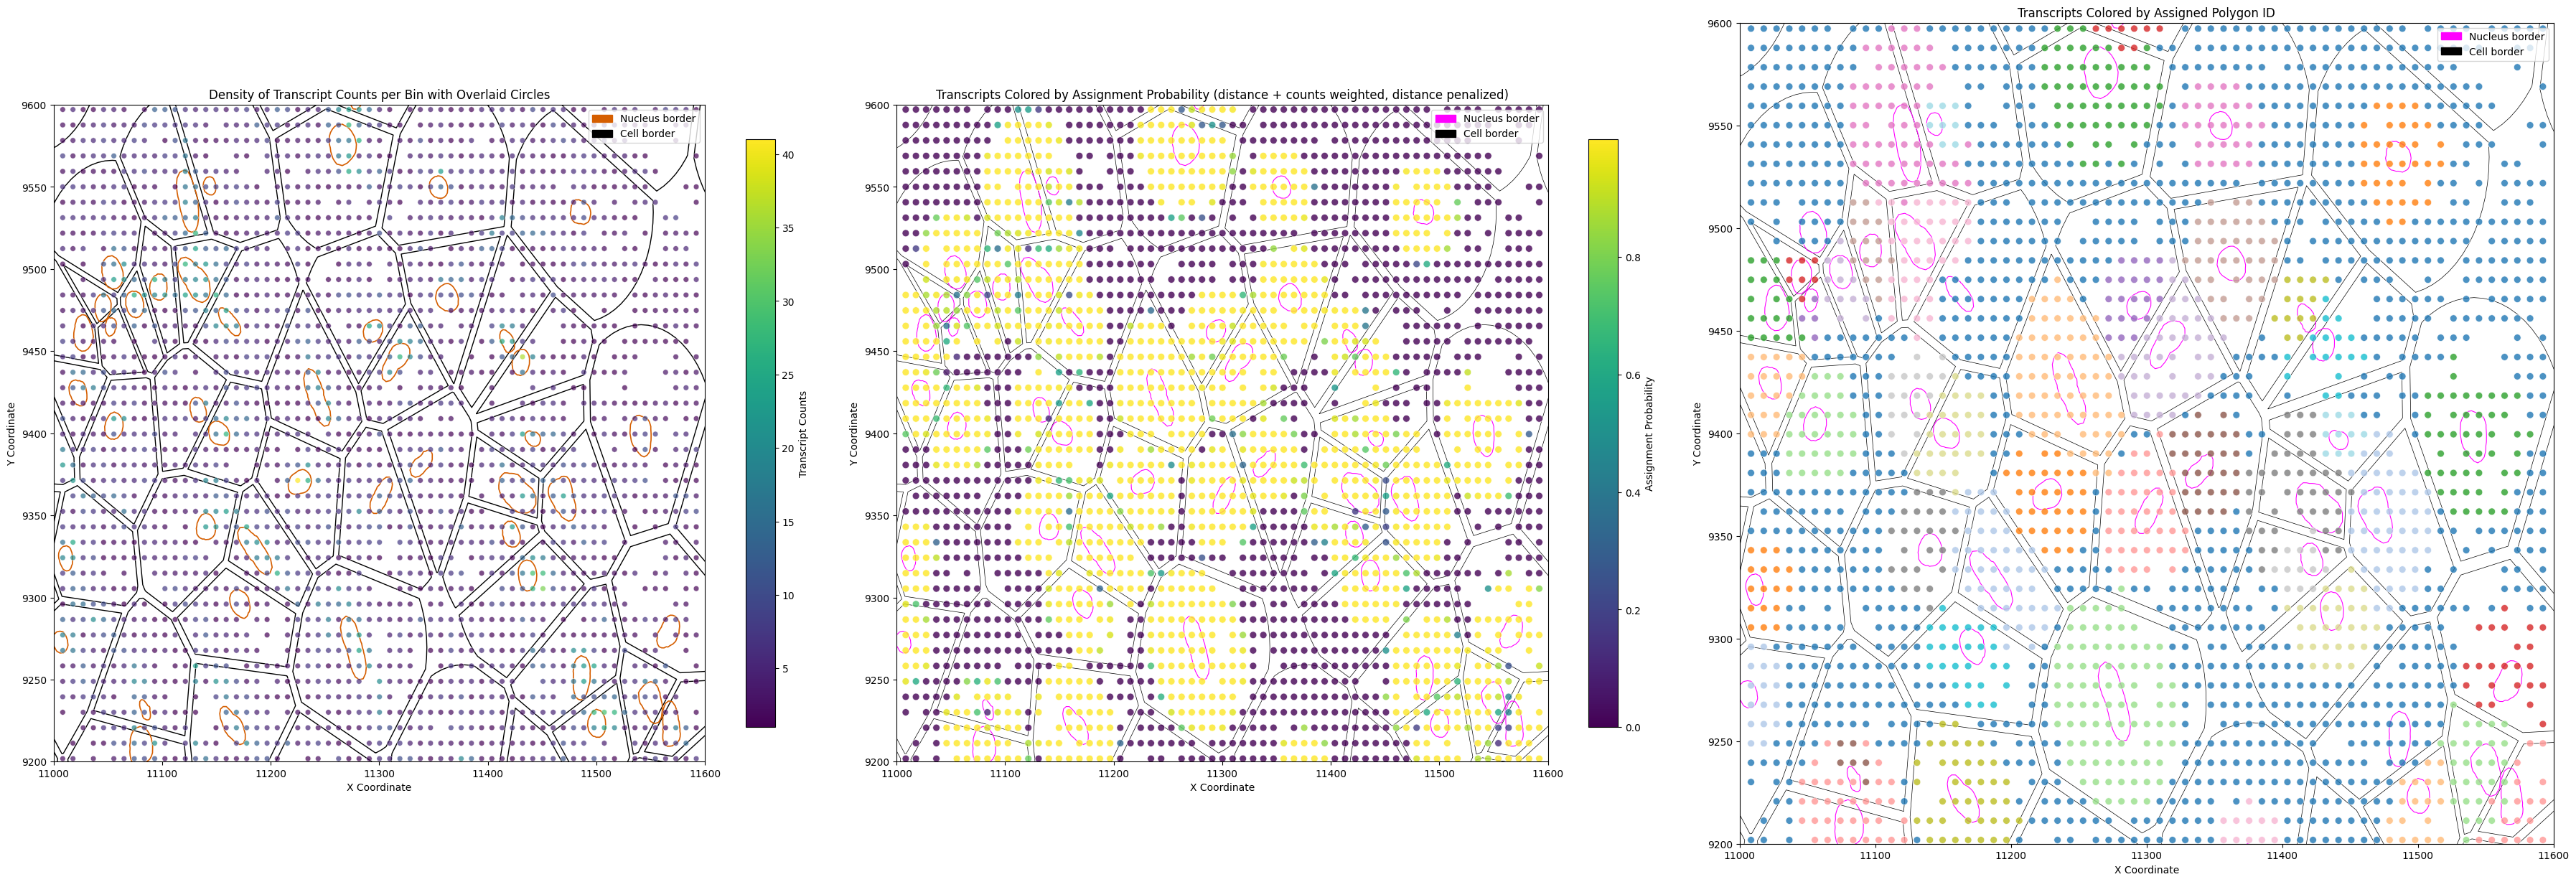

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch
from shapely.geometry import box
import geopandas as gpd

# Define bounding box
bbox = (11000, 9200, 11600, 9600)  # xmin, ymin, xmax, ymax

# Define colors with better contrast and accessibility
cell_border_color = '#000000'  # Black
nucleus_border_color = '#D55E00'  # Dark orange (distinguishable for color blindness)

# Create a subplot layout with 3 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(36, 12))  # 3 plots in one row

# Define a function to create the density plot (the first plot in your original request)
def plot_density(ax):
    # Plot the GeoDataFrame polygons within the bounding box
    gdf_clip = gdf[gdf.intersects(box(*bbox))]  # Filter GeoDataFrame
    gdf_clip.plot(ax=ax, edgecolor=cell_border_color, facecolor='none', linewidth=1.0)

    stardist_clip = stardist[stardist.intersects(box(*bbox))]  # Filter GeoDataFrame
    stardist_clip.plot(ax=ax, edgecolor=nucleus_border_color, facecolor='none', linewidth=1.2)

    # Extract and filter coordinates from the AnnData object
    coords_df = pd.DataFrame(adata.obs[['center_x', 'center_y', 'total_counts']])
    coords_df = coords_df.dropna()  # Drop any rows with NaN values

    # Filter coordinates based on the bounding box
    coords_df_filtered = coords_df[
        (coords_df['center_x'] >= bbox[0]) &
        (coords_df['center_x'] <= bbox[2]) &
        (coords_df['center_y'] >= bbox[1]) &
        (coords_df['center_y'] <= bbox[3])
    ]

    # Overlay the points on the plot
    sns.scatterplot(
        x=coords_df_filtered['center_x'],
        y=coords_df_filtered['center_y'],
        hue=coords_df_filtered['total_counts'],
        palette='viridis',
        ax=ax,
        legend=None,
        marker='o',
        s=30,  # Adjust size as needed
        alpha=0.7
    )

    # Set plot limits based on bounding box
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=coords_df_filtered['total_counts'].min(), vmax=coords_df_filtered['total_counts'].max()))
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('Transcript Counts')

    # Add legend
    legend_elements = [
        Patch(color=nucleus_border_color, label='Nucleus border'),
        Patch(color=cell_border_color, label='Cell border'),
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    # Set title and labels
    ax.set_title('Density of Transcript Counts per Bin with Overlaid Circles')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

# Define a function to create the transcript assignment plot (for the second dataset)
def plot_transcripts_with_assignments(ax, transcripts_with_assignments, title):
    # Plot the GeoDataFrame polygons (cell borders) within the bounding box
    gdf_clip.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)

    # Plot the nucleus borders within the bounding box
    stardist_clip.plot(ax=ax, edgecolor='magenta', facecolor='none', linewidth=0.8)

    # Plot the transcript data points, colored by assignment probability
    sns.scatterplot(
        x=transcripts_with_assignments['center_x'],
        y=transcripts_with_assignments['center_y'],
        hue=transcripts_with_assignments['assignment_probability'],
        palette='viridis',
        ax=ax,
        marker='o',
        s=50,  # Adjust size as needed
        alpha=0.8
    )

    # Set plot limits based on bounding box
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])

    # Add colorbar for assignment probability
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=transcripts_with_assignments['assignment_probability'].min(), vmax=transcripts_with_assignments['assignment_probability'].max()))
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('Assignment Probability')

    # Add legend for nucleus and cell borders
    legend_elements = [
        Patch(color='magenta', label='Nucleus border'),
        Patch(color='black', label='Cell border'),
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

# Define a function to create the third plot with transcript assignments colored by polygon ID
def plot_transcripts_by_polygon_id(ax, transcripts_with_assignments, title):
    # Plot the GeoDataFrame polygons (cell borders) within the bounding box
    gdf_clip.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)

    # Plot the nucleus borders within the bounding box
    stardist_clip.plot(ax=ax, edgecolor='magenta', facecolor='none', linewidth=0.8)

    # Plot the transcript data points, colored by polygon ID
    sns.scatterplot(
        x=transcripts_with_assignments['center_x'],
        y=transcripts_with_assignments['center_y'],
        hue=transcripts_with_assignments['assigned_polygon_id'],  # Color by polygon ID
        palette='tab20',  # Use a categorical colormap
        ax=ax,
        marker='o',
        s=50,  # Adjust size as needed
        alpha=0.8
    )

    # Set plot limits based on bounding box
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])

    # Add legend for nucleus and cell borders
    legend_elements = [
        Patch(color='magenta', label='Nucleus border'),
        Patch(color='black', label='Cell border'),
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

# Plot the density plot as the first plot
plot_density(axes[0])

# Plot the transcript assignment by probability (second plot)
plot_transcripts_with_assignments(axes[1], transcripts_with_assignments2, 'Transcripts Colored by Assignment Probability (distance + counts weighted, distance penalized)')

# Plot the transcript assignment by polygon ID (third plot)
plot_transcripts_by_polygon_id(axes[2], transcripts_with_assignments2, 'Transcripts Colored by Assigned Polygon ID')

# Adjust layout for better spacing
plt.tight_layout()

# Show the final plots
plt.show()
